# `importing libearies and reading data `

In [204]:
import random
import statistics
import numpy as np
from scipy.signal import butter, filtfilt,sosfilt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
import math
import pandas as pd

In [205]:
normal_train_path="Normal&LBBB/Normal_Train.txt"
normal_test_path = "Normal&LBBB/Normal_Test.txt"
lbbb_train_path = "Normal&LBBB/LBBB_Train.txt"
lbbb_test_path = "Normal&LBBB/LBBB_Test.txt"

In [206]:
FS=360
LOW_CUT=0.5
HIGH_CUT=40

In [207]:
def plot(numbers:list,title):
    # Generate x-coordinates (index of each number)
    x = list(range(len(numbers)))

    # Draw a line through the points
    plt.plot(x, numbers, color='blue', linestyle='-', linewidth=2)

    # Add labels and a legend
    plt.xlabel('Index')
    plt.ylabel('ECG')
    plt.title(title)
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

In [208]:
def getDataEntries(filename):
    data = []
    with open(filename, "r") as file:
        for line in file:
            parts = line.strip().split('|')
            data.append(parts)
    data = [i[:len(i)-1] for i in data]
    new_data = []
    for inner_list in data:
        new_inner_list = [float(element) for element in inner_list]
        new_data.append(new_inner_list)
    return new_data

In [209]:
normal_train=getDataEntries(normal_train_path)
normal_test = getDataEntries(normal_test_path)
lbbb_train=getDataEntries(lbbb_train_path)
lbbb_test=getDataEntries(lbbb_test_path)

data_train = normal_train + lbbb_train
data_test = normal_test + lbbb_test

C:\Users\HP\AppData\Local\Temp\ipykernel_908\522643902.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


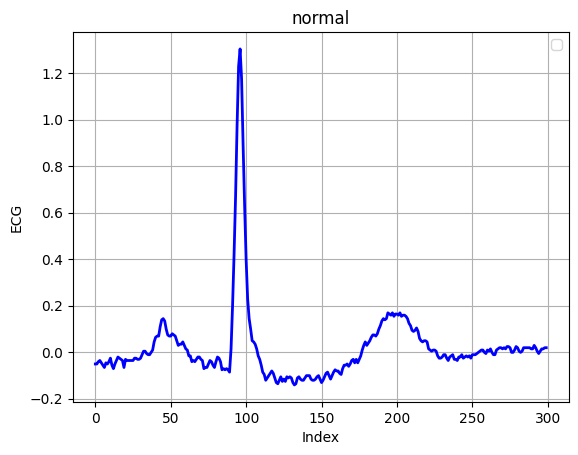

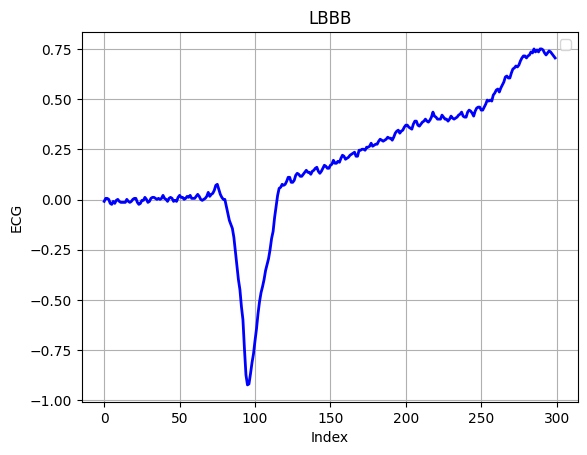

In [210]:
plot(normal_train[0],"normal")
plot(lbbb_train[0],"LBBB")

# `data preprocessing`

## removing mean

In [211]:
def remove_mean(signal:list):
    mean= statistics.mean(signal)
    new_signal=[i-mean for i in signal]
    return new_signal

def remove_mean_for_all(signals:list):
    new_signals=[]
    for i in range(len(signals)):
        new_signals.append(remove_mean(signals[i]))
    return new_signals

In [212]:
normal_train=remove_mean_for_all(normal_train)
normal_test=remove_mean_for_all(normal_test)
lbbb_test=remove_mean_for_all(lbbb_test)
lbbb_train=remove_mean_for_all(lbbb_train)

C:\Users\HP\AppData\Local\Temp\ipykernel_908\522643902.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


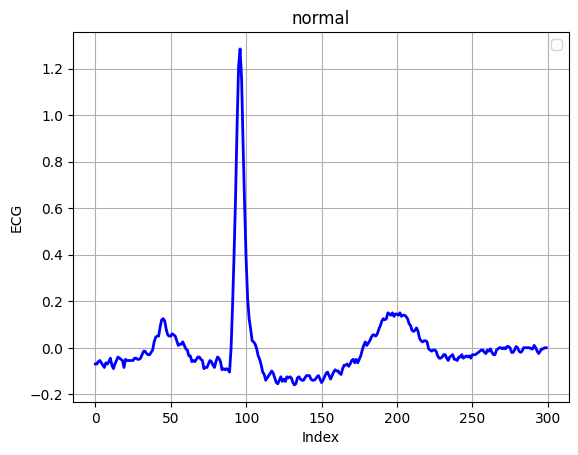

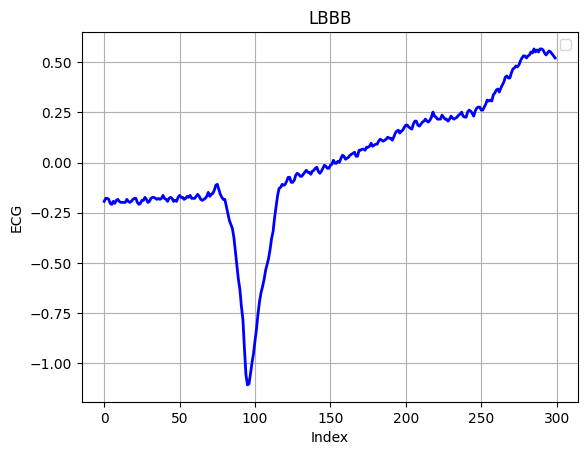

In [213]:
plot(normal_train[0],"normal")
plot(lbbb_train[0],"LBBB")

## applying bandbass filtter

In [214]:
def create_bandpass_filter(lowcut, highcut, fs, order=4):
    """
    Create Butterworth bandpass filter.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter_batch(signals, fs, lowcut=0.5, highcut=40, order=4):
    """
    Apply Butterworth bandpass filter to multiple signals.
    
    Parameters:
    signals (numpy.ndarray): 2D array where each row is a signal
    """
    b, a = create_bandpass_filter(lowcut, highcut, fs, order)
    return list(np.apply_along_axis(lambda x: filtfilt(b, a, x), 1, signals))

In [215]:
normal_train=apply_bandpass_filter_batch(normal_train,FS)
normal_test=apply_bandpass_filter_batch(normal_test,FS)
lbbb_test=apply_bandpass_filter_batch(lbbb_test,FS)
lbbb_train=apply_bandpass_filter_batch(lbbb_train,FS)

C:\Users\HP\AppData\Local\Temp\ipykernel_908\522643902.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


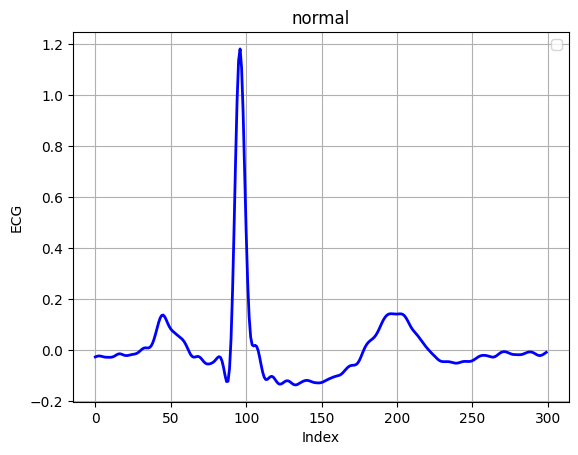

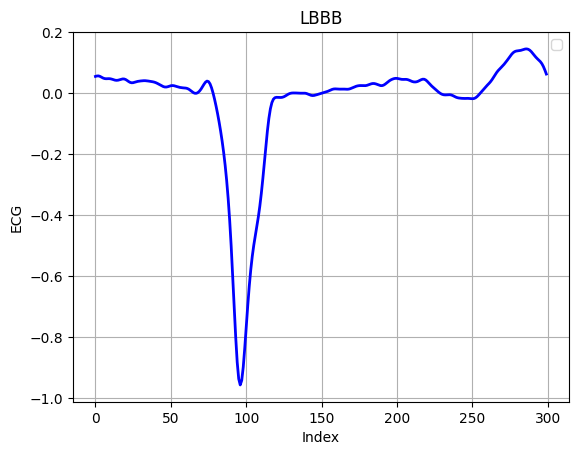

In [216]:
plot(normal_train[0],"normal")
plot(lbbb_train[0],"LBBB")

## normalizing the data

In [217]:
def normalize_signal(signal, new_min=0, new_max=1):
    """
    Normalize a signal to a specified range [new_min, new_max].

    Parameters:
        signal (array-like): Input signal to be normalized.
        new_min (float): Minimum value of the normalized signal.
        new_max (float): Maximum value of the normalized signal.

    Returns:
        numpy.ndarray: Normalized signal.
    """
    signal = np.array(signal)
    old_min = np.min(signal)
    old_max = np.max(signal)
    
    if old_min == old_max:
        raise ValueError("Signal has no variation (all values are the same).")
    
    normalized_signal = (signal - old_min) / (old_max - old_min)  # Scale to [0, 1]
    normalized_signal = normalized_signal * (new_max - new_min) + new_min  # Scale to [new_min, new_max]
    
    return normalized_signal
def normalize_for_all(signals:list):
    new_signals=[]
    for i in range(len(signals)):
        new_signals.append(normalize_signal(signals[i],-1,1))
    return new_signals    

In [218]:
normal_train=normalize_for_all(normal_train)
normal_test=normalize_for_all(normal_test)
lbbb_test=normalize_for_all(lbbb_test)
lbbb_train=normalize_for_all(lbbb_train)

C:\Users\HP\AppData\Local\Temp\ipykernel_908\522643902.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


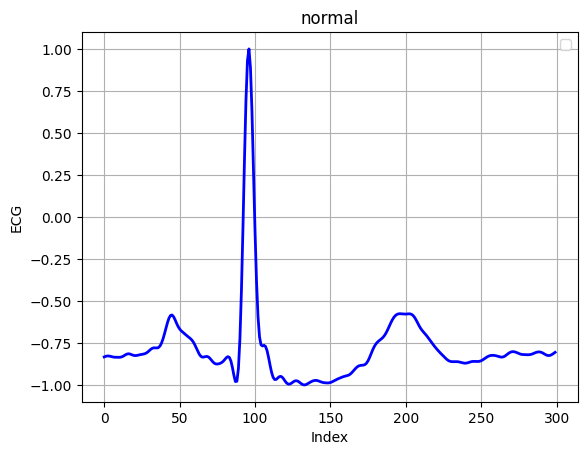

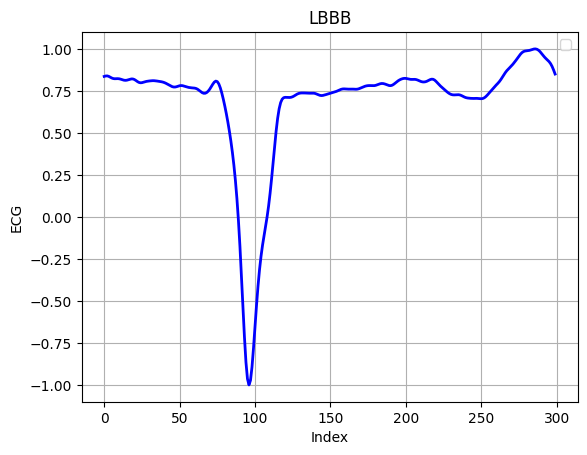

In [219]:
plot(normal_train[0],"normal")
plot(lbbb_train[0],"LBBB")

# Wavelet

In [220]:
train= normal_train+lbbb_train
test=normal_test+lbbb_test
y_train=[0]*len(normal_train)+[1]*len(lbbb_train)
y_test=[0]*len(normal_test)+[1]*len(lbbb_test)

Detecting the best combination:

C:\Users\HP\AppData\Local\Temp\ipykernel_908\522643902.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


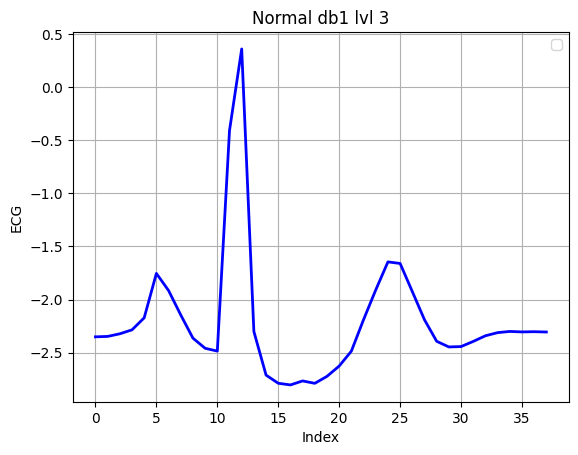

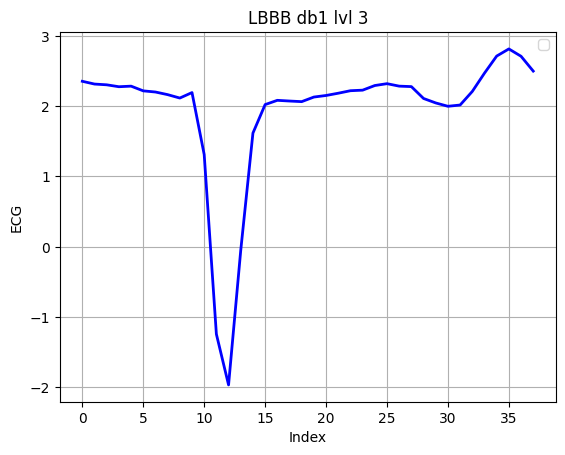

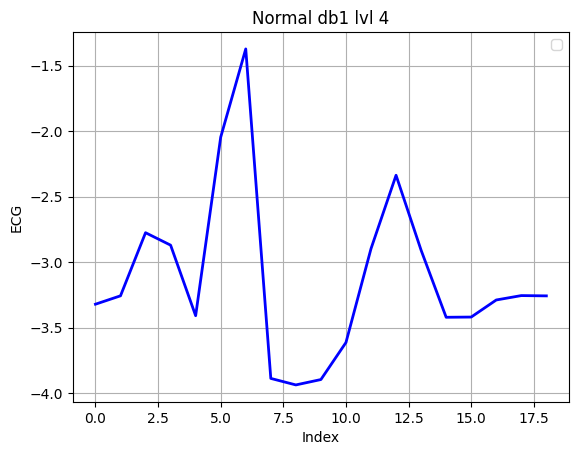

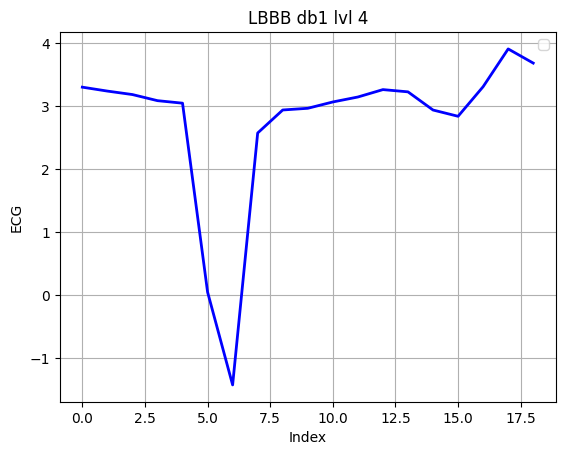

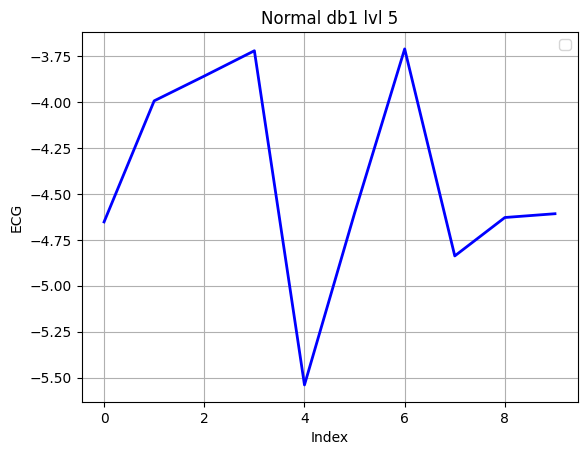

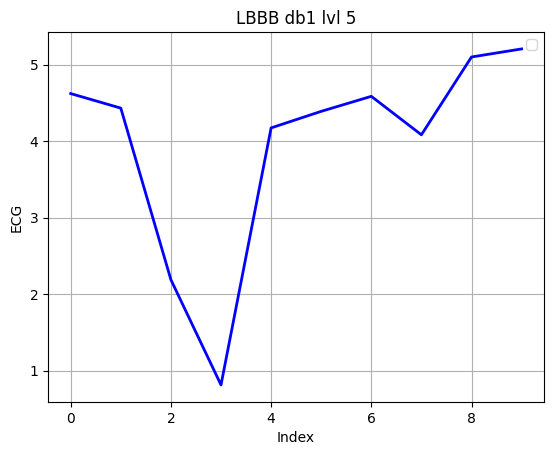

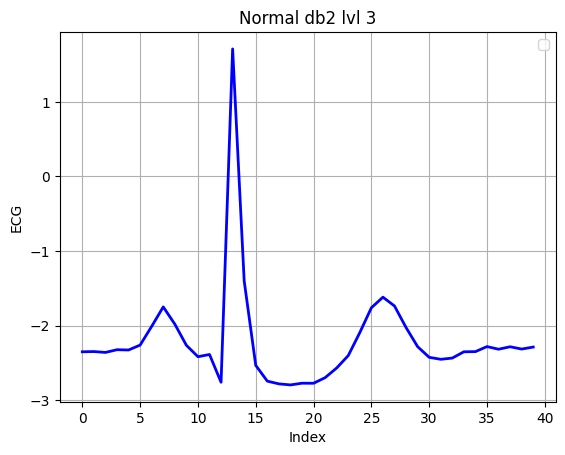

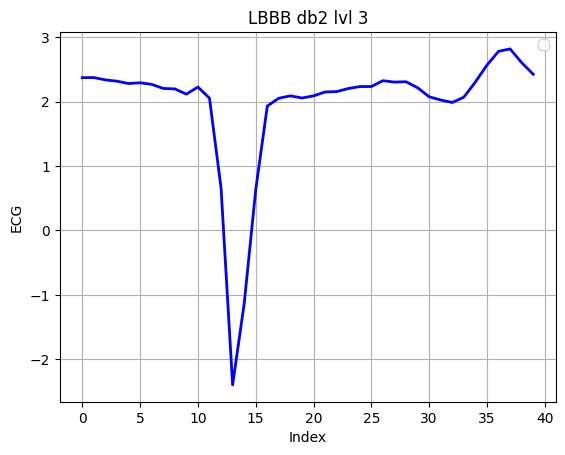

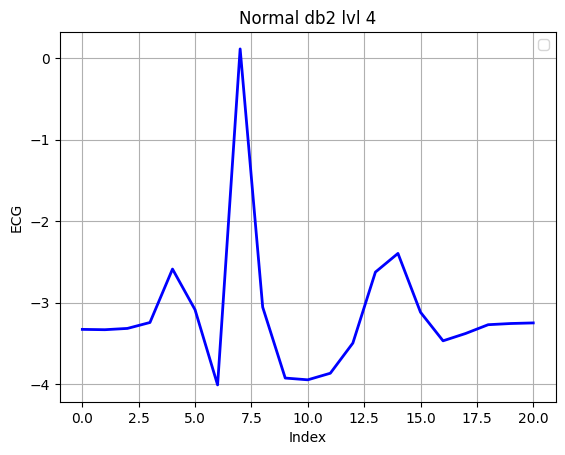

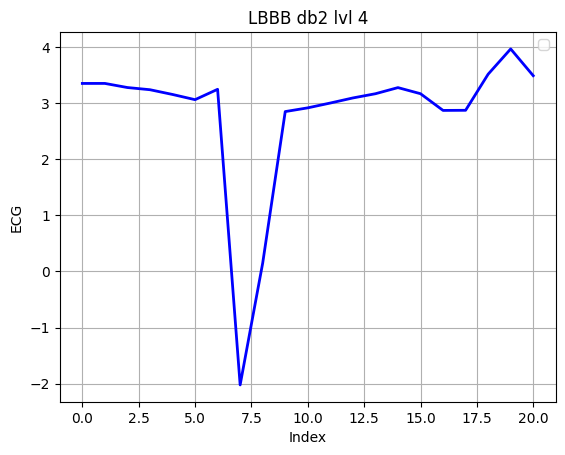

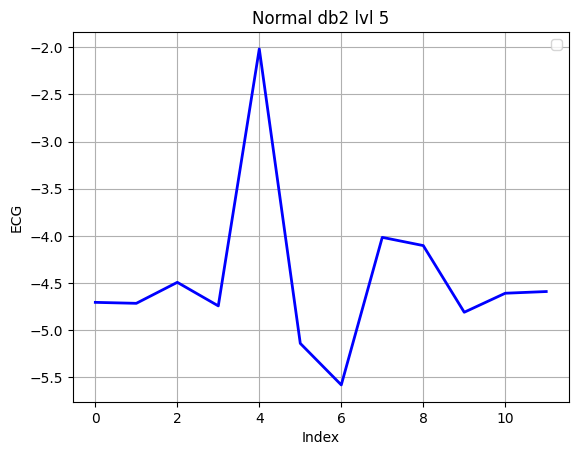

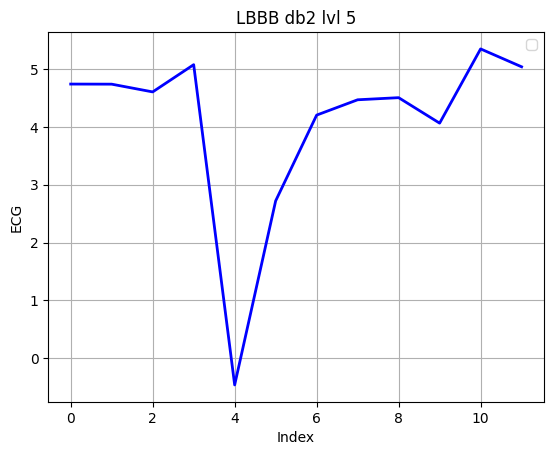

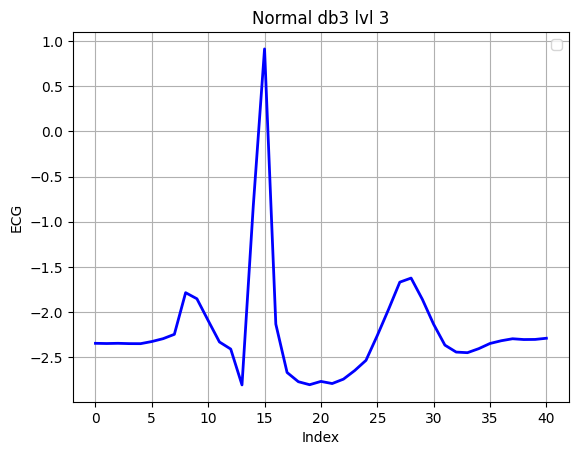

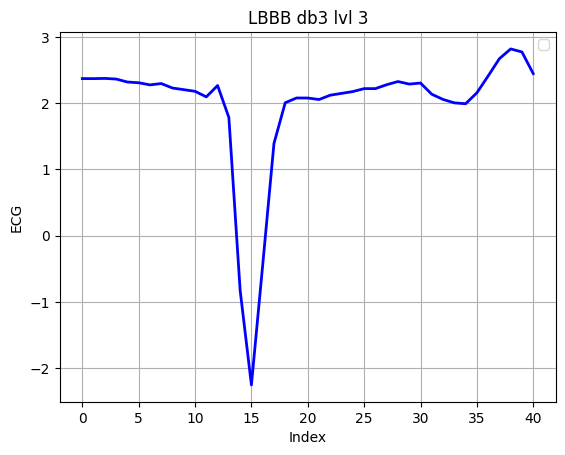

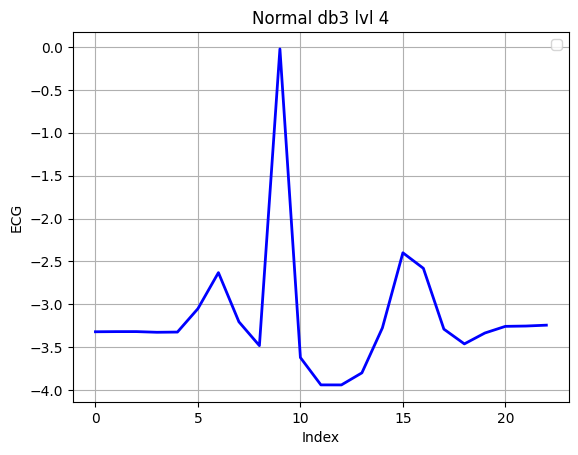

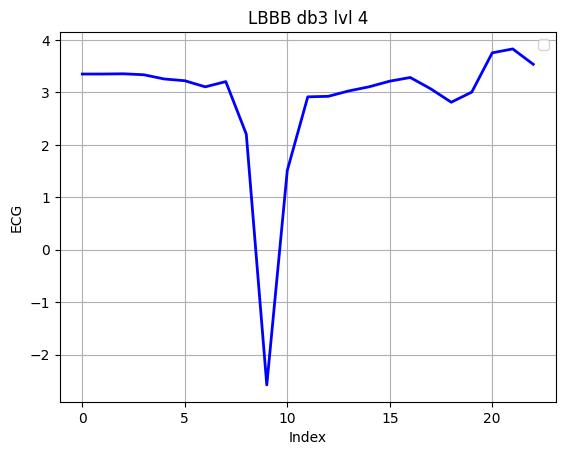

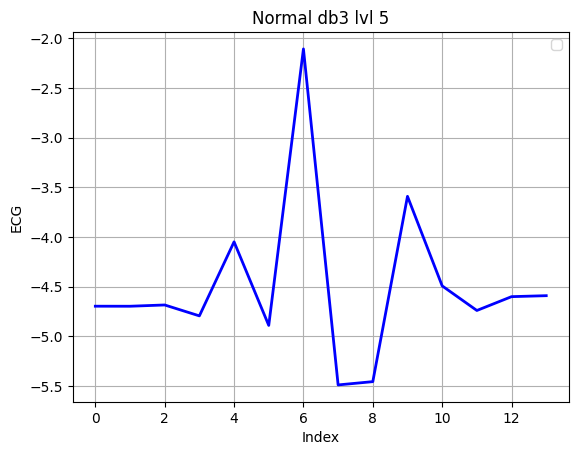

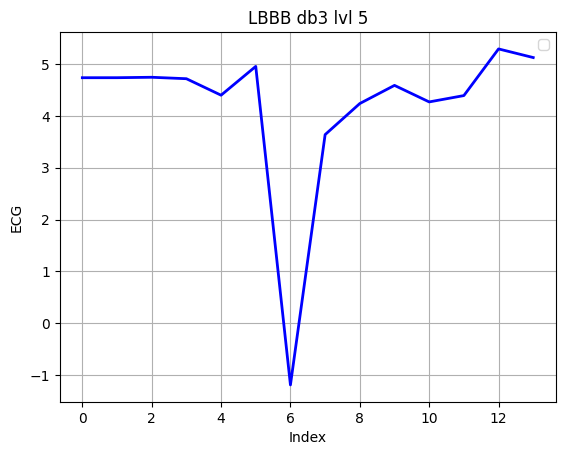

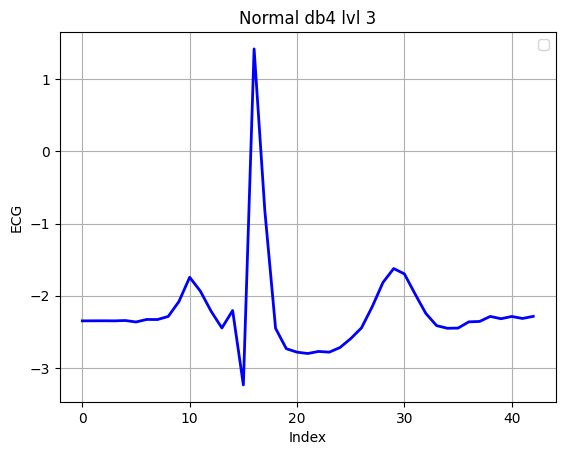

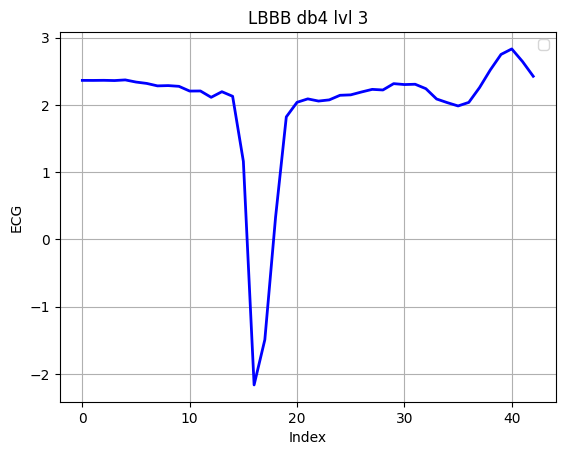

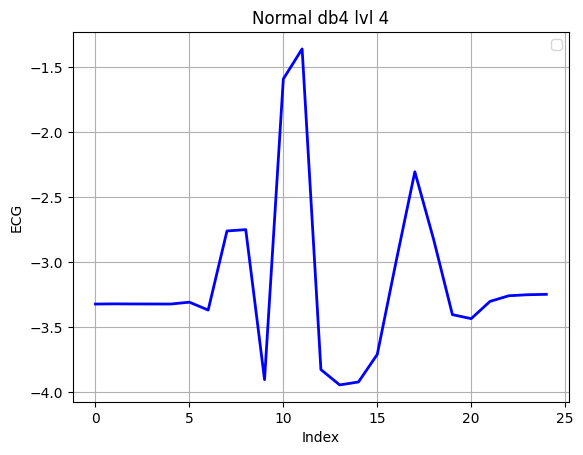

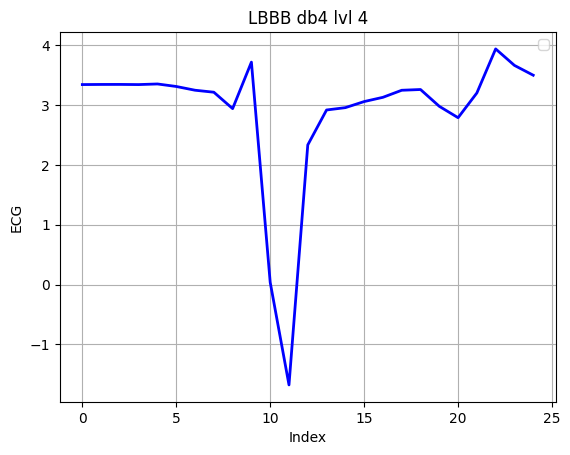

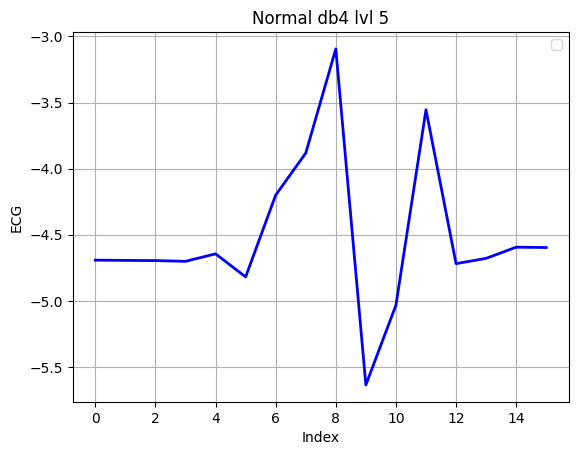

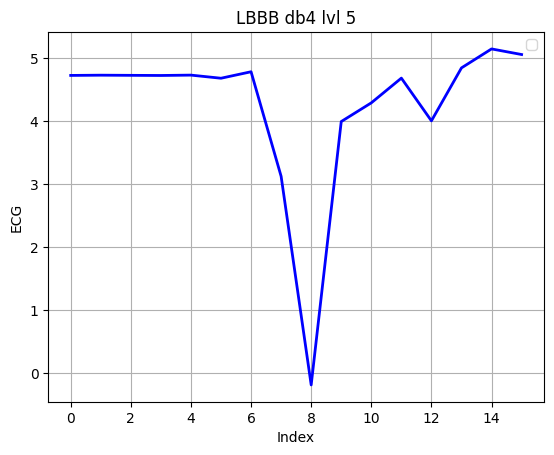

In [221]:
for i in range(1, 5):
    for j in range(3, 6):
        WAVELET_FAMILY = 'db' + str(i)
        LEVEL = j
        normal_coeff=pywt.wavedec(train[0],wavelet=WAVELET_FAMILY,level=LEVEL)
        plot(normal_coeff[0],"Normal " + WAVELET_FAMILY + " lvl " + str(LEVEL))
        LBBB_coeff=pywt.wavedec(train[len(normal_train)],wavelet=WAVELET_FAMILY,level=LEVEL)
        plot(LBBB_coeff[0],"LBBB " + WAVELET_FAMILY + " lvl " + str(LEVEL))


For normal signal: the best combinations is ['db2' with level 3, 'db2' with level 4]

For LBBB signal: the best combinations is ['db2' with level 4, 'db2' with level 5]

## applying wavelet

In [222]:
WAVELET_FAMILY='db2'
LEVEL = 3
train_app=[]
test_app=[]

In [223]:
for i in range(len(train)):
    train_coeff=pywt.wavedec(train[i],wavelet=WAVELET_FAMILY,level=LEVEL)
    app=train_coeff[0]
    train_app.append(app)
    
for i in range(len(test)):
    test_coeff=pywt.wavedec(test[i],wavelet=WAVELET_FAMILY,level=LEVEL)
    app=test_coeff[0]
    test_app.append(app)

C:\Users\HP\AppData\Local\Temp\ipykernel_908\522643902.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


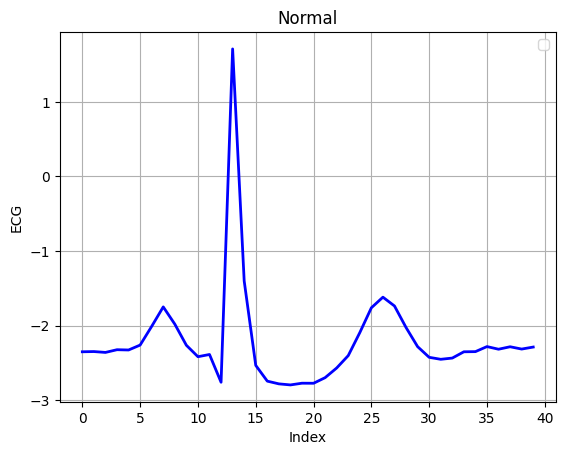

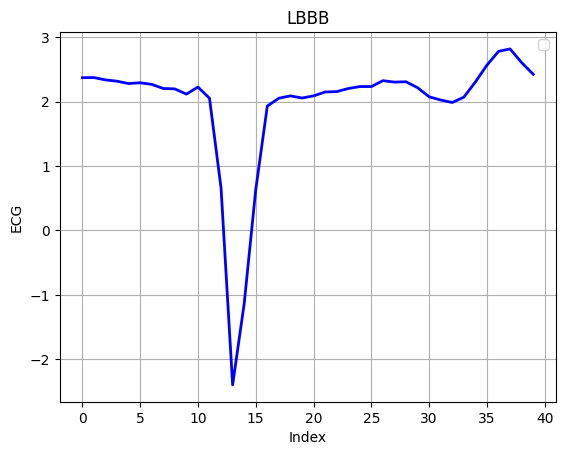

In [224]:
plot(train_app[0],"Normal")
plot(train_app[len(normal_train)],"LBBB")

## transforming data to statstical features

In [225]:
import scipy.stats as stats

def calculate_statistics(signal):
    mean = np.mean(signal)
    std_deviation = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    return mean, std_deviation, skewness, kurtosis

In [226]:
# Calculate statistics for each signal
statistics = [calculate_statistics(signal) for signal in train_app]
statistics_df = pd.DataFrame(statistics, columns=['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'])

train_df = statistics_df

In [227]:
# Calculate statistics for each signal
statistics = [calculate_statistics(signal) for signal in test_app]
statistics_df = pd.DataFrame(statistics, columns=['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'])

test_df = statistics_df

In [228]:
train_labels = [0] * len(normal_train) + [1] * len(lbbb_train)
test_labels = [0] * len(normal_test) + [1] * len(lbbb_test)

In [229]:
train_df['Label'] = train_labels
train_df

,Mean,Standard Deviation,Skewness,Kurtosis,Label
0,-2.209321,0.706894,4.245535,20.812578,0
1,-2.231773,0.720386,4.381279,21.784326,0
2,-2.204316,0.724514,4.218012,20.527704,0
3,-2.198512,0.716926,4.298561,21.345697,0
4,-2.152692,0.729966,4.281453,21.373684,0
...,...,...,...,...,...
594,1.305828,1.027181,-1.671910,4.148625,1
595,1.606541,0.970487,-2.507240,7.632638,1
596,1.472635,0.988884,-2.088275,6.111347,1
597,1.440582,0.972567,-2.109268,6.212387,1


In [230]:
print("duplicates = ", train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

duplicates =  199


In [231]:
print("Zeros = ", train_df[train_df['Label'] == 0].shape[0])
print("Ones = ", train_df[train_df['Label'] == 1].shape[0])

Zeros =  200
Ones =  200


In [232]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# `modeling`

In [233]:
#split data_train into x, y (target)
X_train = train_df.drop('Label', axis=1) #all columns except target
y_train = train_df['Label']  #target -> Label column a
X_test = test_df
y_test = test_labels

In [234]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# Define models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=11),
    "SVM": SVC(C=0.2,kernel='rbf'),
    "Random Forest": RandomForestClassifier(n_estimators=1, random_state=42,max_depth=1)
}
for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    accuracy_train = accuracy_score(y_train,y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f"Accuracy train: {accuracy_train * 100:.2f}%")
    print(f"Accuracy test: {accuracy_test * 100:.2f}%")


Evaluating model: KNN
Accuracy train: 98.75%
Accuracy test: 98.15%

Evaluating model: SVM
Accuracy train: 98.75%
Accuracy test: 97.64%

Evaluating model: Random Forest
Accuracy train: 99.50%
Accuracy test: 87.21%


# KNN

In [235]:
model = KNeighborsClassifier(n_neighbors=11)
print(f"\nEvaluating model: KNN")
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Metrics
accuracy_train = accuracy_score(y_train,y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy train: {accuracy_train * 100:.2f}%")
print(f"Accuracy test: {accuracy_test * 100:.2f}%")


Evaluating model: KNN
Accuracy train: 98.75%
Accuracy test: 98.15%


In [236]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Assuming you have already trained your KNN model and have test data
# best_knn should be your trained KNN model
# X_test is your test features dataframe
# y_test is your test labels

# Calculate permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': abs(result.importances_mean)
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
              Feature  Importance
3            Kurtosis    0.312626
2            Skewness    0.068855
0                Mean    0.002525
1  Standard Deviation    0.000000


Drop unimportant Features

In [237]:
X_train = X_train.drop('Standard Deviation', axis=1)
X_test = X_test.drop('Standard Deviation', axis=1)

In [238]:
model = KNeighborsClassifier(n_neighbors=11)
print(f"\nEvaluating model: KNN")
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Metrics
accuracy_train = accuracy_score(y_train,y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy train: {accuracy_train * 100:.2f}%")
print(f"Accuracy test: {accuracy_test * 100:.2f}%")


Evaluating model: KNN
Accuracy train: 98.75%
Accuracy test: 98.15%


In [239]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Assuming you have already trained your KNN model and have test data
# best_knn should be your trained KNN model
# X_test is your test features dataframe
# y_test is your test labels

# Calculate permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': abs(result.importances_mean)
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
    Feature  Importance
2  Kurtosis    0.313468
1  Skewness    0.068855
0      Mean    0.002525
